#Q1

VEHICLE ROUTING PROBLEM : Using the given dataset and finding optimal solution for intial 11 demand points

Used pulp to find the optimal solution.

In [ ]:
!pip install pulp

import math
import time
import pulp
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 38.8 MB/s eta 0:00:00


***** Optimal/Feasible Solution Found *****

Total Distance: 361.6
Routes (using 1-indexed node numbers):
Route 1 (Load: 35): [1, 2, 8, 1]
Route 2 (Load: 95): [1, 7, 4, 3, 5, 9, 10, 11, 6, 1]
Total Load: 130
Solution Time: 17.64 seconds


<ipython-input-3-8aeb3ec26356>:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(routes))


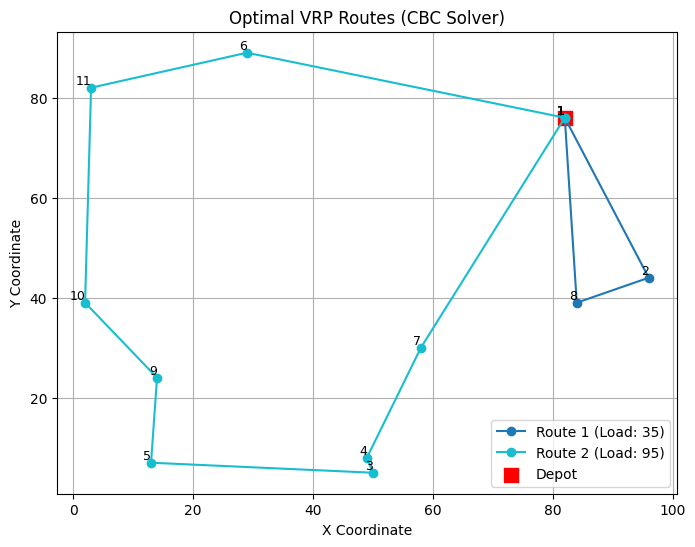

In [ ]:
# Node format: (node, x, y)
node_coords = [
    (1, 82, 76),  # Depot (node 1, demand = 0)
    (2, 96, 44),
    (3, 50, 5),
    (4, 49, 8),
    (5, 13, 7),
    (6, 29, 89),
    (7, 58, 30),
    (8, 84, 39),
    (9, 14, 24),
    (10, 2, 39),
    (11, 3, 82)
]

# Demands (index 0 is depot)
demands = [0, 19, 21, 6, 19, 7, 12, 16, 6, 16, 8]
vehicle_capacity = 100
n = len(node_coords)
depot = 0  # using 0-indexing for depot

# Create Distance Matrix
def compute_euclidean_distance(c1, c2):
    return math.hypot(c1[1] - c2[1], c1[2] - c2[2])

distance_matrix = [[0.0]*n for _ in range(n)]
for i in range(n):
    for j in range(n):
        if i != j:
            distance_matrix[i][j] = compute_euclidean_distance(node_coords[i], node_coords[j])
        else:
            distance_matrix[i][j] = 0.0

# Create the LP problem
prob = pulp.LpProblem("CVRP", pulp.LpMinimize)

# Decision variables:
x = {}
for i in range(n):
    for j in range(n):
        if i != j:
            x[(i,j)] = pulp.LpVariable(f"x_{i}_{j}", cat=pulp.LpBinary)

# MTZ variables:
u = {}
for i in range(1, n):
    u[i] = pulp.LpVariable(f"u_{i}", lowBound=demands[i], upBound=vehicle_capacity, cat=pulp.LpContinuous)

# Objective: minimize total distance traveled
prob += pulp.lpSum(distance_matrix[i][j] * x[(i,j)] for i in range(n) for j in range(n) if i != j)

# Constraint 1: Each customer (j ≠ depot) must have exactly one incoming arc.
for j in range(1, n):
    prob += pulp.lpSum(x[(i,j)] for i in range(n) if i != j) == 1, f"Incoming_{j}"

# Constraint 2: Each customer (i ≠ depot) must have exactly one outgoing arc.
for i in range(1, n):
    prob += pulp.lpSum(x[(i,j)] for j in range(n) if i != j) == 1, f"Outgoing_{i}"

# Constraint 3: Flow conservation at the depot (number of departures equals arrivals).
prob += (pulp.lpSum(x[(depot,j)] for j in range(1, n)) ==
         pulp.lpSum(x[(i,depot)] for i in range(1, n))), "Depot_flow"

# Constraint 4: MTZ Subtour Elimination for i,j in {1,..., n-1}, i != j.
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            prob += u[i] - u[j] + vehicle_capacity * x[(i,j)] <= vehicle_capacity - demands[j], f"MTZ_{i}_{j}"

# Solve the model using CBC (default solver for PuLP) with a time limit of 60 seconds.
solver = pulp.PULP_CBC_CMD(timeLimit=60, msg=0)
start_time = time.time()
prob.solve(solver)
solution_time = time.time() - start_time

# Extract and Print the Solution
if pulp.LpStatus[prob.status] in ["Optimal", "Not Solved", "Integer Feasible"]:
    # Extract arcs used in the solution (x value > 0.5)
    used_arcs = {(i,j): pulp.value(x[(i,j)]) for (i,j) in x if pulp.value(x[(i,j)]) is not None and pulp.value(x[(i,j)]) > 0.5}
    routes = []
    route_loads = []
    # Reconstruct routes starting from the depot.
    for j in range(1, n):
        if (depot, j) in used_arcs:
            route = [depot, j]
            next_node = j
            while True:
                found = False
                for k in range(n):
                    if next_node != k and (next_node, k) in used_arcs:
                        route.append(k)
                        found = True
                        if k == depot:
                            break
                        next_node = k
                        break
                if not found or route[-1] == depot:
                    break
            routes.append(route)
            # Compute route load (sum demands for nodes excluding the depot)
            load = sum(demands[node] for node in route if node != depot)
            route_loads.append(load)

    total_distance = sum(distance_matrix[i][j] for route in routes for i, j in zip(route, route[1:]))
    total_load = sum(route_loads)

    print("***** Optimal/Feasible Solution Found *****\n")
    print("Total Distance:", round(total_distance, 1))
    print("Routes (using 1-indexed node numbers):")
    for idx, route in enumerate(routes):
        route_print = [node + 1 for node in route]
        print(f"Route {idx+1} (Load: {route_loads[idx]}): {route_print}")
    print("Total Load:", total_load)
    print(f"Solution Time: {solution_time:.2f} seconds")
else:
    print("No feasible solution found!")

# Plot the Optimal Routes with Load Labels
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', len(routes))
for idx, route in enumerate(routes):
    xs = []
    ys = []
    for node in route:
        # node is 0-indexed; retrieve coordinates from node_coords
        _, x_coord, y_coord = node_coords[node]
        xs.append(x_coord)
        ys.append(y_coord)
    plt.plot(xs, ys, marker='o', label=f"Route {idx+1} (Load: {route_loads[idx]})", color=colors(idx))
    for node in route:
        _, x_coord, y_coord = node_coords[node]
        plt.text(x_coord, y_coord, str(node+1), fontsize=9, ha='right', va='bottom')
depot_x, depot_y = node_coords[0][1], node_coords[0][2]
plt.scatter([depot_x], [depot_y], c='red', s=100, marker='s', label='Depot')
plt.title("Optimal VRP Routes (CBC Solver)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid(True)
plt.show()


Gives two possible routes.

#Q2

Now using the same logic as used in the above code and finding the optimal solution for 11,12 and 13 demand points.

The computation time is increasing as we can observe from the solution output below.


----- Solution for 11 Demand Points -----
Status: Optimal
Solution Time: 11.41 seconds
Total Distance: 361.6
Routes:
Route 1 (Load: 95): [0, 5, 10, 9, 8, 4, 2, 3, 6, 0]
Route 2 (Load: 35): [0, 7, 1, 0]


<ipython-input-4-dde93d9b84a1>:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(routes))


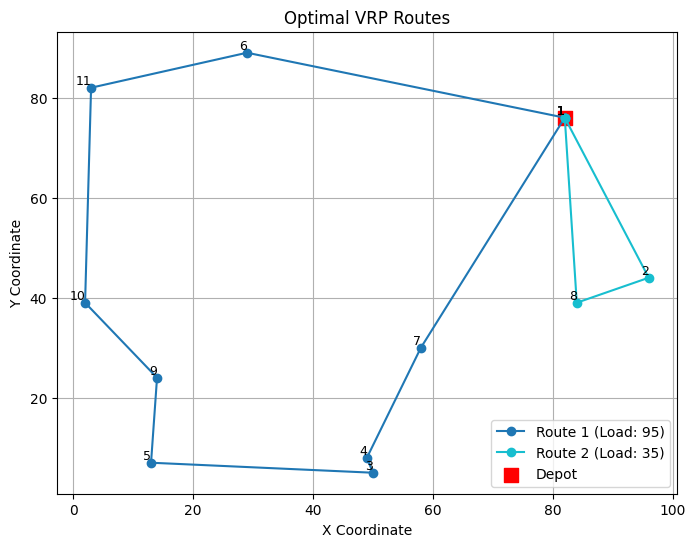


----- Solution for 12 Demand Points -----
Status: Optimal
Solution Time: 24.85 seconds
Total Distance: 412.03
Routes:
Route 1 (Load: 47): [0, 1, 7, 6, 0]
Route 2 (Load: 97): [0, 5, 10, 9, 8, 11, 4, 2, 3, 0]


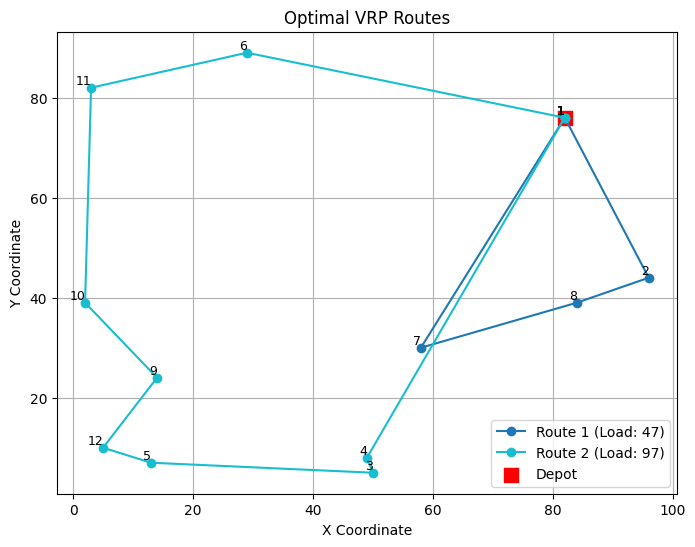


----- Solution for 13 Demand Points -----
Status: Optimal
Solution Time: 59.94 seconds
Total Distance: 428.18
Routes:
Route 1 (Load: 97): [0, 3, 2, 8, 4, 11, 9, 10, 5, 0]
Route 2 (Load: 68): [0, 12, 1, 7, 6, 0]


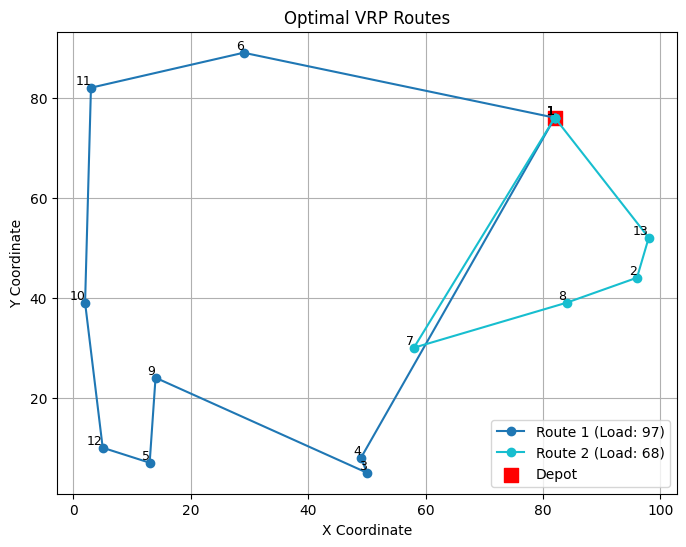

In [ ]:
import math
import time
import pulp
import matplotlib.pyplot as plt

# Data for the problem
node_coords = [(1, 82, 76),(2, 96, 44),(3, 50, 5),(4, 49, 8),(5, 13, 7),(6, 29, 89),(7, 58, 30),(8, 84, 39),
    (9, 14, 24),(10, 2, 39),(11, 3, 82),(12, 5, 10),(13, 98, 52)]

demands = [0, 19, 21, 6, 19, 7, 12, 16, 6, 16, 8, 14, 21]
vehicle_capacity = 100

def compute_euclidean_distance(c1, c2):
    return math.hypot(c1[1] - c2[1], c1[2] - c2[2])

def create_distance_matrix(nodes):
    n = len(nodes)
    distance_matrix = [[0.0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = compute_euclidean_distance(nodes[i], nodes[j])
    return distance_matrix

def solve_cvrp(n):
    depot = 0
    distance_matrix = create_distance_matrix(node_coords[:n])
    current_demands = demands[:n]

    prob = pulp.LpProblem("CVRP", pulp.LpMinimize)

    x = {(i, j): pulp.LpVariable(f"x_{i}_{j}", cat=pulp.LpBinary) for i in range(n) for j in range(n) if i != j}
    u = {i: pulp.LpVariable(f"u_{i}", lowBound=current_demands[i], upBound=vehicle_capacity, cat=pulp.LpContinuous) for i in range(1, n)}

    # Objective Function
    prob += pulp.lpSum(distance_matrix[i][j] * x[(i, j)] for i in range(n) for j in range(n) if i != j)

    # Constraints
    for j in range(1, n):
        prob += pulp.lpSum(x[(i, j)] for i in range(n) if i != j) == 1
        prob += pulp.lpSum(x[(j, i)] for i in range(n) if i != j) == 1

    prob += pulp.lpSum(x[(depot, j)] for j in range(1, n)) == pulp.lpSum(x[(i, depot)] for i in range(1, n))

    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                prob += u[i] - u[j] + vehicle_capacity * x[(i, j)] <= vehicle_capacity - current_demands[j]

    # Solve
    solver = pulp.PULP_CBC_CMD(timeLimit=60, msg=0)
    start_time = time.time()
    prob.solve(solver)
    solution_time = time.time() - start_time

    print(f"\n----- Solution for {n} Demand Points -----")
    print(f"Status: {pulp.LpStatus[prob.status]}")
    print(f"Solution Time: {solution_time:.2f} seconds")

    if pulp.LpStatus[prob.status] == "Optimal":
        total_distance = pulp.value(prob.objective)
        print(f"Total Distance: {round(total_distance, 2)}")

        # Extract routes
        routes = []
        route_loads = []
        used_arcs = {(i, j) for (i, j) in x if pulp.value(x[(i, j)]) > 0.5}

        for j in range(1, n):
            if (depot, j) in used_arcs:
                route = [depot, j]
                next_node = j
                load = current_demands[j]
                while True:
                    for k in range(n):
                        if (next_node, k) in used_arcs:
                            route.append(k)
                            load += current_demands[k]
                            if k == depot:
                                break
                            next_node = k
                            break
                    if route[-1] == depot:
                        break
                routes.append(route)
                route_loads.append(load)

        print("Routes:")
        for i, route in enumerate(routes):
            print(f"Route {i+1} (Load: {route_loads[i]}): {route}")

        # Plot Routes
        plt.figure(figsize=(8, 6))
        colors = plt.cm.get_cmap('tab10', len(routes))
        for idx, route in enumerate(routes):
            xs = [node_coords[node][1] for node in route]
            ys = [node_coords[node][2] for node in route]
            plt.plot(xs, ys, marker='o', label=f"Route {idx+1} (Load: {route_loads[idx]})", color=colors(idx))
            for node in route:
                plt.text(node_coords[node][1], node_coords[node][2], str(node+1), fontsize=9, ha='right', va='bottom')
        depot_x, depot_y = node_coords[0][1], node_coords[0][2]
        plt.scatter([depot_x], [depot_y], c='red', s=100, marker='s', label='Depot')
        plt.title("Optimal VRP Routes")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.grid(True)
        plt.show()

# Run for 11, 12, and 13 demand points
solve_cvrp(11)
solve_cvrp(12)
solve_cvrp(13)


#Q3

Now using simulated annealing to solve the problem

Running for A-n32-k5
Temp: 100.00 | Cost: 930.68 | Gap: 18.71% | Time: 0.59s
Temp: 200.00 | Cost: 910.41 | Gap: 16.12% | Time: 0.86s
Temp: 300.00 | Cost: 890.33 | Gap: 13.56% | Time: 0.68s
Temp: 400.00 | Cost: 836.90 | Gap: 6.75% | Time: 0.31s
Temp: 500.00 | Cost: 916.52 | Gap: 16.90% | Time: 0.31s
Temp: 600.00 | Cost: 904.32 | Gap: 15.35% | Time: 0.30s
Temp: 700.00 | Cost: 895.35 | Gap: 14.20% | Time: 0.31s
Temp: 800.00 | Cost: 939.19 | Gap: 19.80% | Time: 0.32s
Temp: 900.00 | Cost: 958.94 | Gap: 22.31% | Time: 0.30s
Temp: 1000.00 | Cost: 867.72 | Gap: 10.68% | Time: 0.31s

Best result for A-n32-k5:
Initial Temp = 400.0
Best Cost = 836.90
Gap = 6.75%
Time = 0.31s
Running for A-n80-k10
Temp: 100.00 | Cost: 2224.43 | Gap: 26.17% | Time: 0.62s
Temp: 200.00 | Cost: 2392.48 | Gap: 35.71% | Time: 0.61s
Temp: 300.00 | Cost: 2369.74 | Gap: 34.41% | Time: 0.62s
Temp: 400.00 | Cost: 2332.49 | Gap: 32.30% | Time: 0.64s
Temp: 500.00 | Cost: 2383.10 | Gap: 35.17% | Time: 0.63s
Temp: 600.00 | Cost:

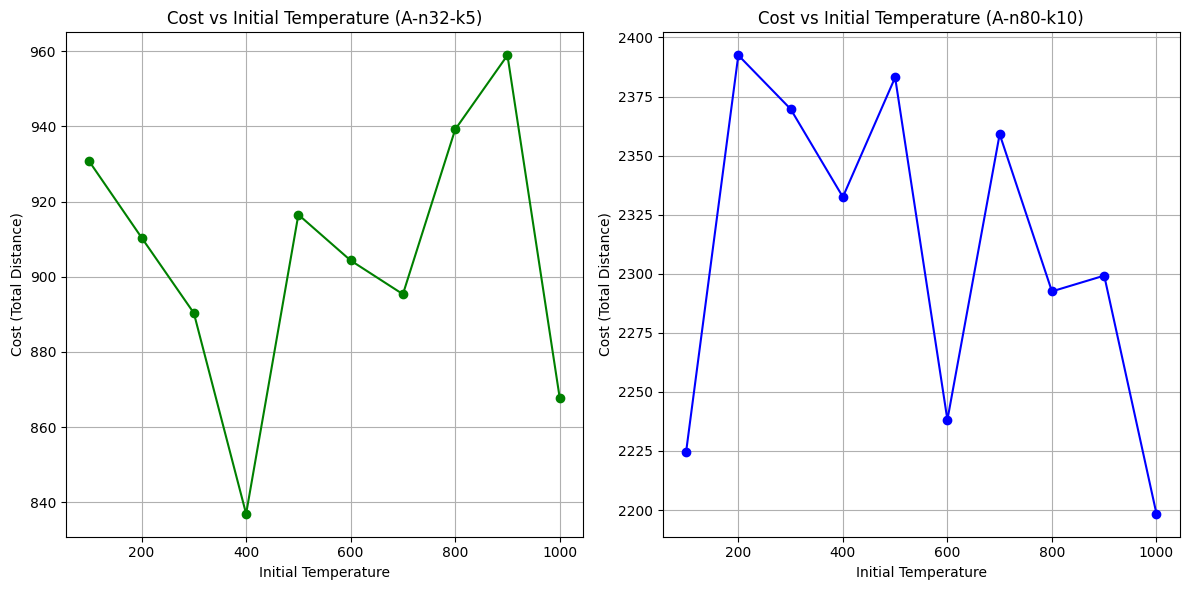

In [18]:
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import copy

def calc_distance(point1, point2):
    return math.hypot(point1[0] - point2[0], point1[1] - point2[1])

def create_distance_matrix(locations):
    n = len(locations)
    matrix = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            matrix[i][j] = calc_distance(locations[i], locations[j])
    return matrix

def calculate_route_distance(route, distance_matrix, depot=0):
    total_distance = 0.0
    for path in route:
        if path:
            total_distance += distance_matrix[depot][path[0]]
            for i in range(len(path)-1):
                total_distance += distance_matrix[path[i]][path[i+1]]
            total_distance += distance_matrix[path[-1]][depot]
    return total_distance

def calculate_route_load(route, demands):
    return sum(demands[i] for i in route)

def is_solution_feasible(route_plan, demands, capacity):
    for path in route_plan:
        if calculate_route_load(path, demands) > capacity:
            return False
    return True

def greedy_initial_solution(demands, capacity):
    total_customers = len(demands)
    routes = []
    route = []
    load = 0
    for i in range(1, total_customers):
        if load + demands[i] <= capacity:
            route.append(i)
            load += demands[i]
        else:
            routes.append(route)
            route = [i]
            load = demands[i]
    if route:
        routes.append(route)
    return routes

def relocate(route_plan, demands, capacity):
    new_plan = copy.deepcopy(route_plan)
    r1 = random.randint(0, len(new_plan)-1)
    if not new_plan[r1]:
        return new_plan
    cust = random.choice(new_plan[r1])
    new_plan[r1].remove(cust)
    r2 = random.randint(0, len(new_plan)-1)
    pos = random.randint(0, len(new_plan[r2]))
    new_plan[r2].insert(pos, cust)
    new_plan = [r for r in new_plan if r != []]
    if is_solution_feasible(new_plan, demands, capacity):
        return new_plan
    else:
        return route_plan

def swap(route_plan, demands, capacity):
    new_plan = copy.deepcopy(route_plan)
    r1, r2 = random.sample(range(len(new_plan)), 2)
    if not new_plan[r1] or not new_plan[r2]:
        return new_plan
    i = random.randint(0, len(new_plan[r1])-1)
    j = random.randint(0, len(new_plan[r2])-1)
    new_plan[r1][i], new_plan[r2][j] = new_plan[r2][j], new_plan[r1][i]
    if is_solution_feasible(new_plan, demands, capacity):
        return new_plan
    else:
        return route_plan

def generate_neighbor(route_plan, demands, capacity):
    return relocate(route_plan, demands, capacity) if random.random() < 0.5 else swap(route_plan, demands, capacity)

def simulated_annealing(locations, demands, capacity, initial_temp, cooling_rate, iterations, depot=0):
    distance_matrix = create_distance_matrix(locations)
    current_solution = greedy_initial_solution(demands, capacity)
    current_cost = calculate_route_distance(current_solution, distance_matrix, depot)
    best_solution = copy.deepcopy(current_solution)
    best_cost = current_cost

    temp = initial_temp
    start_time = time.time()
    for _ in range(iterations):
        neighbor_solution = generate_neighbor(current_solution, demands, capacity)
        neighbor_cost = calculate_route_distance(neighbor_solution, distance_matrix, depot)
        delta = neighbor_cost - current_cost
        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_solution = neighbor_solution
            current_cost = neighbor_cost
            if current_cost < best_cost:
                best_solution = copy.deepcopy(current_solution)
                best_cost = current_cost
        temp *= cooling_rate
    return best_solution, best_cost, time.time() - start_time

def run_simulation(dataset_name, locations, demands, capacity, optimal_cost, initial_temp_range, cooling_rate, iterations):
    best_cost = float('inf')
    best_temp = None
    best_solution = None
    best_time = None
    costs = []

    print(f"Running for {dataset_name}")
    for initial_temp in initial_temp_range:
        solution, cost, elapsed_time = simulated_annealing(locations, demands, capacity, initial_temp, cooling_rate, iterations)
        gap = ((cost - optimal_cost) / optimal_cost) * 100
        print(f"Temp: {initial_temp:.2f} | Cost: {cost:.2f} | Gap: {gap:.2f}% | Time: {elapsed_time:.2f}s")
        costs.append(cost)
        if cost < best_cost:
            best_cost = cost
            best_temp = initial_temp
            best_solution = solution
            best_time = elapsed_time

    overall_gap = ((best_cost - optimal_cost) / optimal_cost) * 100
    print(f"\nBest result for {dataset_name}:")
    print(f"Initial Temp = {best_temp}")
    print(f"Best Cost = {best_cost:.2f}")
    print(f"Gap = {overall_gap:.2f}%")
    print(f"Time = {best_time:.2f}s")

    return best_temp, costs, best_cost, overall_gap, best_time

# Example Data (A-n32-k5 and A-n80-k10)
coords_32 = [(82,76), (96,44), (50,5), (49,8), (13,7), (29,89), (58,30), (84,39), (14,24), (2,39),
             (3,82), (5,10), (98,52), (84,25), (61,59), (1,65), (88,51), (91,2), (19,32), (93,3),
             (50,93), (98,14), (5,42), (42,9), (61,62), (9,97), (80,55), (57,69), (23,15), (20,70),
             (85,60), (98,5)]
demands_32 = [0,19,21,6,19,7,12,16,6,16,8,14,21,16,3,22,18,19,1,24,8,12,4,8,24,24,2,20,15,2,14,9]
optimal_32 = 784

coords_80 = [(92,92), (88,58), (70,6), (57,59), (0,98), (61,38), (65,22), (91,52), (59,2), (3,54),
             (95,38), (80,28), (66,42), (79,74), (99,25), (20,43), (40,3), (50,42), (97,0), (21,19),
             (36,21), (100,61), (11,85), (69,35), (69,22), (29,35), (14,9), (50,33), (89,17), (57,44),
             (60,25), (48,42), (17,93), (21,50), (77,18), (2,4), (63,83), (68,6), (41,95), (48,54),
             (98,73), (26,38), (69,76), (40,1), (65,41), (14,86), (32,39), (14,24), (96,5), (82,98),
             (23,85), (63,69), (87,19), (56,75), (15,63), (10,45), (7,30), (31,11), (36,93), (50,31),
             (49,52), (39,10), (76,40), (83,34), (33,51), (0,15), (52,82), (52,82), (46,6), (3,26),
             (46,80), (94,30), (26,76), (75,92), (57,51), (34,21), (28,80), (59,66), (51,16), (87,11)]
demands_80 = [0,24,22,23,5,11,23,26,9,23,9,14,16,12,2,2,6,20,26,12,15,13,26,17,7,12,4,4,20,10,
              9,2,9,1,2,2,12,14,23,21,13,13,23,3,6,23,11,2,7,13,10,3,6,13,2,14,7,21,7,22,13,
              22,18,22,6,2,11,5,9,9,5,12,2,12,19,6,14,2,2,24]
optimal_80 = 1763

# Parameters
capacity = 100
cooling_rate = 0.995
iterations = 10000
initial_temp_range = np.linspace(100, 1000, 10)

# Run experiments
best_temp_32, costs_32, best_cost_32, gap_32, best_time_32 = run_simulation("A-n32-k5", coords_32, demands_32, capacity, optimal_32, initial_temp_range, cooling_rate, iterations)
best_temp_80, costs_80, best_cost_80, gap_80, best_time_80 = run_simulation("A-n80-k10", coords_80, demands_80, capacity, optimal_80, initial_temp_range, cooling_rate, iterations)

# Plot both results in one figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for A-n32-k5
axs[0].plot(initial_temp_range, costs_32, marker='o', color='green')
axs[0].set_title("Cost vs Initial Temperature (A-n32-k5)")
axs[0].set_xlabel("Initial Temperature")
axs[0].set_ylabel("Cost (Total Distance)")
axs[0].grid(True)

# Plot for A-n80-k10
axs[1].plot(initial_temp_range, costs_80, marker='o', color='blue')
axs[1].set_title("Cost vs Initial Temperature (A-n80-k10)")
axs[1].set_xlabel("Initial Temperature")
axs[1].set_ylabel("Cost (Total Distance)")
axs[1].grid(True)

plt.tight_layout()
plt.show()


#Q4

Using genetic algorithms to find optimal distance.

In [23]:
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt

def calculate_distance(point1, point2):
    return math.hypot(point1[0] - point2[0], point1[1] - point2[1])

def create_distance_matrix(coords):
    num_coords = len(coords)
    matrix = [[0] * num_coords for _ in range(num_coords)]
    for i in range(num_coords):
        for j in range(num_coords):
            matrix[i][j] = calculate_distance(coords[i], coords[j])
    return matrix

def divide_chromosome(chromosome, demands, max_capacity, depot=0):
    """Divide a chromosome into feasible routes based on demands and capacity."""
    routes = []
    current_route = []
    current_load = 0
    for customer in chromosome:
        if current_load + demands[customer] <= max_capacity:
            current_route.append(customer)
            current_load += demands[customer]
        else:
            routes.append(current_route)
            current_route = [customer]
            current_load = demands[customer]
    if current_route:
        routes.append(current_route)
    return routes

def calculate_total_distance(solution, distance_matrix, depot=0):
    """Calculate the total distance for a given solution (routes)."""
    total_distance = 0.0
    for route in solution:
        if route:
            total_distance += distance_matrix[depot][route[0]]
            for i in range(len(route) - 1):
                total_distance += distance_matrix[route[i]][route[i + 1]]
            total_distance += distance_matrix[route[-1]][depot]
    return total_distance

def calculate_route_load(route, demands):
    return sum(demands[i] for i in route)

def is_solution_feasible(solution, demands, max_capacity):
    """Check if a solution is feasible (all routes do not exceed the capacity)."""
    for route in solution:
        if calculate_route_load(route, demands) > max_capacity:
            return False
    return True

def generate_initial_population(num_customers, population_size):
    population = []
    for _ in range(population_size):
        individual = list(range(1, num_customers + 1))
        random.shuffle(individual)
        population.append(individual)
    return population

def evaluate_individual(individual, demands, max_capacity, distance_matrix, depot=0):
    """Evaluate an individual solution (chromosome) by calculating its total distance."""
    routes = divide_chromosome(individual, demands, max_capacity, depot)
    total_cost = calculate_total_distance(routes, distance_matrix, depot)
    return total_cost, routes

def tournament_selection(population, fitness_scores, tournament_size=3):
    """Select an individual using tournament selection."""
    selected = random.sample(list(zip(population, fitness_scores)), tournament_size)
    selected.sort(key=lambda x: x[1])  # Sort by fitness (ascending)
    return selected[0][0]

def order_crossover(parent1, parent2):
    """Apply order crossover between two parents to generate a child."""
    size = len(parent1)
    a, b = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[a:b + 1] = parent1[a:b + 1]
    remaining_genes = [gene for gene in parent2 if gene not in child]
    j = 0
    for i in range(size):
        if child[i] is None:
            child[i] = remaining_genes[j]
            j += 1
    return child

def swap_mutation(individual, mutation_probability=0.1):
    """Apply swap mutation to an individual with a given mutation probability."""
    individual_copy = individual.copy()
    for i in range(len(individual)):
        if random.random() < mutation_probability:
            j = random.randint(0, len(individual) - 1)
            individual_copy[i], individual_copy[j] = individual_copy[j], individual_copy[i]
    return individual_copy

def genetic_algorithm(coords, demands, max_capacity, population_size=50, generations=1000,
                       crossover_prob=0.8, mutation_prob=0.1, depot=0):
    num_customers = len(coords) - 1
    distance_matrix = create_distance_matrix(coords)

    population = generate_initial_population(num_customers, population_size)

    best_cost = float('inf')
    best_individual = None
    best_routes = None

    start_time = time.time()
    for generation in range(generations):
        fitness_scores = []
        routes_population = []
        for individual in population:
            cost, routes = evaluate_individual(individual, demands, max_capacity, distance_matrix, depot)
            fitness_scores.append(cost)
            routes_population.append(routes)
            if cost < best_cost:
                best_cost = cost
                best_individual = individual
                best_routes = routes
        new_population = []
        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitness_scores)
            parent2 = tournament_selection(population, fitness_scores)
            if random.random() < crossover_prob:
                child = order_crossover(parent1, parent2)
            else:
                child = parent1.copy()
            child = swap_mutation(child, mutation_prob)
            new_population.append(child)
        population = new_population
    execution_time = time.time() - start_time
    return best_routes, best_cost, execution_time

def run_ga_experiment(dataset_name, coords, demands, max_capacity, optimal_value):
    start_time = time.time()
    best_routes, best_cost, execution_time = genetic_algorithm(coords, demands, max_capacity, population_size=50, generations=1000, crossover_prob=0.8, mutation_prob=0.1, depot=0)
    elapsed_time = time.time() - start_time
    gap_percentage = ((best_cost - optimal_value) / optimal_value) * 100
    print(f"\nDataset: {dataset_name}")
    print(f"Best Total Distance: {best_cost:.2f}")
    print(f"Percentage Gap: {gap_percentage:.2f}%")
    print(f"GA Computation Time: {execution_time:.2f} s")
    # Display routes
    print("Routes (1-indexed nodes):")
    for idx, route in enumerate(best_routes):
        load = sum(demands[node] for node in route)
        print(f"Route {idx + 1} (Load: {load}): {['1'] + [node + 1 for node in route] + ['1']}")
    return best_cost, execution_time, gap_percentage, best_routes

# Define coordinates and demands for both datasets
dataset_32_coords = [
    (82,76), (96,44), (50,5), (49,8), (13,7), (29,89), (58,30), (84,39), (14,24), (2,39),
    (3,82), (5,10), (98,52), (84,25), (61,59), (1,65), (88,51), (91,2), (19,32), (93,3),
    (50,93), (98,14), (5,42), (42,9), (61,62), (9,97), (80,55), (57,69), (23,15), (20,70),
    (85,60), (98,5)
]
dataset_32_demands = [0,19,21,6,19,7,12,16,6,16,8,14,21,16,3,22,18,19,1,24,8,12,4,8,24,24,2,20,15,2,14,9]
optimal_value_32 = 784

dataset_80_coords = [
    (92,92), (88,58), (70,6), (57,59), (0,98), (61,38), (65,22), (91,52), (59,2), (3,54),
    (95,38), (80,28), (66,42), (79,74), (99,25), (20,43), (40,3), (50,42), (97,0), (21,19),
    (36,21), (100,61), (11,85), (69,35), (69,22), (29,35), (14,9), (50,33), (89,17), (57,44),
    (60,25), (48,42), (17,93), (21,50), (77,18), (2,4), (63,83), (68,6), (41,95), (48,54),
    (98,73), (26,38), (69,76), (40,1), (65,41), (14,86), (32,39), (14,24), (96,5), (82,98),
    (23,85), (63,69), (87,19), (56,75), (15,63), (10,45), (7,30), (31,11), (36,93), (50,31),
    (49,52), (39,10), (76,40), (83,34), (33,51), (0,15), (52,82), (52,82), (46,6), (3,26),
    (46,80), (94,30), (26,76), (75,92), (57,51), (34,21), (28,80), (59,66), (51,16), (87,11)
]
dataset_80_demands = [0,24,22,23,5,11,23,26,9,23,9,14,16,12,2,2,6,20,26,12,15,13,26,17,7,12,4,4,20,10,
                      9,2,9,1,2,2,12,14,23,21,13,13,23,3,6,23,11,2,7,13,10,3,6,13,2,14,7,21,7,22,13,
                      22,18,22,6,2,11,5,9,9,5,12,2,12,19,6,14,2,2,24]
optimal_value_80 = 1763

# Run the experiments for both datasets
print("Genetic Algorithm for CVRP")
cost_32, time_32, gap_32, _ = run_ga_experiment("A-n32-k5", dataset_32_coords, dataset_32_demands, 100, optimal_value_32)
cost_80, time_80, gap_80, _ = run_ga_experiment("A-n80-k10", dataset_80_coords, dataset_80_demands, 100, optimal_value_80)

# Comparison of results
datasets = ['A-n32-k5', 'A-n80-k10']
costs = [cost_32, cost_80]
times = [time_32, time_80]
gaps = [gap_32, gap_80]



Genetic Algorithm for CVRP

Dataset: A-n32-k5
Best Total Distance: 1392.63
Percentage Gap: 77.63%
GA Computation Time: 1.92 s
Routes (1-indexed nodes):
Route 1 (Load: 99): ['1', 4, 3, 24, 15, 9, 12, 23, 14, 2, 27, '1']
Route 2 (Load: 94): ['1', 6, 19, 30, 25, 28, 11, 26, 21, '1']
Route 3 (Load: 93): ['1', 10, 5, 29, 16, 13, '1']
Route 4 (Load: 81): ['1', 31, 17, 7, 32, 22, 8, '1']
Route 5 (Load: 43): ['1', 20, 18, '1']

Dataset: A-n80-k10
Best Total Distance: 4008.54
Percentage Gap: 127.37%
GA Computation Time: 5.29 s
Routes (1-indexed nodes):
Route 1 (Load: 94): ['1', 73, 77, 18, 3, 65, 69, 9, 14, '1']
Route 2 (Load: 93): ['1', 29, 38, 72, 80, 39, '1']
Route 3 (Load: 94): ['1', 6, 32, 61, 34, 79, 23, 5, 49, 26, 27, 36, 31, '1']
Route 4 (Load: 81): ['1', 74, 42, 11, 8, 51, 35, 16, 59, '1']
Route 5 (Load: 95): ['1', 4, 44, 70, 17, 19, 21, 22, '1']
Route 6 (Load: 98): ['1', 76, 66, 20, 58, 10, 28, 45, 2, '1']
Route 7 (Load: 90): ['1', 64, 55, 46, 40, 60, '1']
Route 8 (Load: 88): ['1', 67

#Q5

Calculating optimal distance for both the datasets using OR tools

In [27]:
!pip install ortools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [28]:
import math
import time
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2


--- VRP Solution for A-n32-k5 ---
Total Distance Traveled: 773

Routes (1-indexed):
  Route 1 (Load 44): [1, 25, 28, 1]
  Route 2 (Load 0): [1, 1]
  Route 3 (Load 98): [1, 7, 4, 3, 24, 29, 5, 12, 15, 1]
  Route 4 (Load 98): [1, 21, 6, 26, 11, 30, 16, 23, 10, 9, 19, 1]
  Route 5 (Load 98): [1, 22, 32, 20, 18, 14, 8, 27, 1]
  Route 6 (Load 0): [1, 1]
  Route 7 (Load 72): [1, 13, 2, 17, 31, 1]
  Route 8 (Load 0): [1, 1]
  Route 9 (Load 0): [1, 1]
  Route 10 (Load 0): [1, 1]
  Route 11 (Load 0): [1, 1]
  Route 12 (Load 0): [1, 1]
  Route 13 (Load 0): [1, 1]
  Route 14 (Load 0): [1, 1]
  Route 15 (Load 0): [1, 1]
  Route 16 (Load 0): [1, 1]
  Route 17 (Load 0): [1, 1]
  Route 18 (Load 0): [1, 1]
  Route 19 (Load 0): [1, 1]
  Route 20 (Load 0): [1, 1]
  Route 21 (Load 0): [1, 1]
  Route 22 (Load 0): [1, 1]
  Route 23 (Load 0): [1, 1]
  Route 24 (Load 0): [1, 1]
  Route 25 (Load 0): [1, 1]
  Route 26 (Load 0): [1, 1]
  Route 27 (Load 0): [1, 1]
  Route 28 (Load 0): [1, 1]
  Route 29 (Load 0)

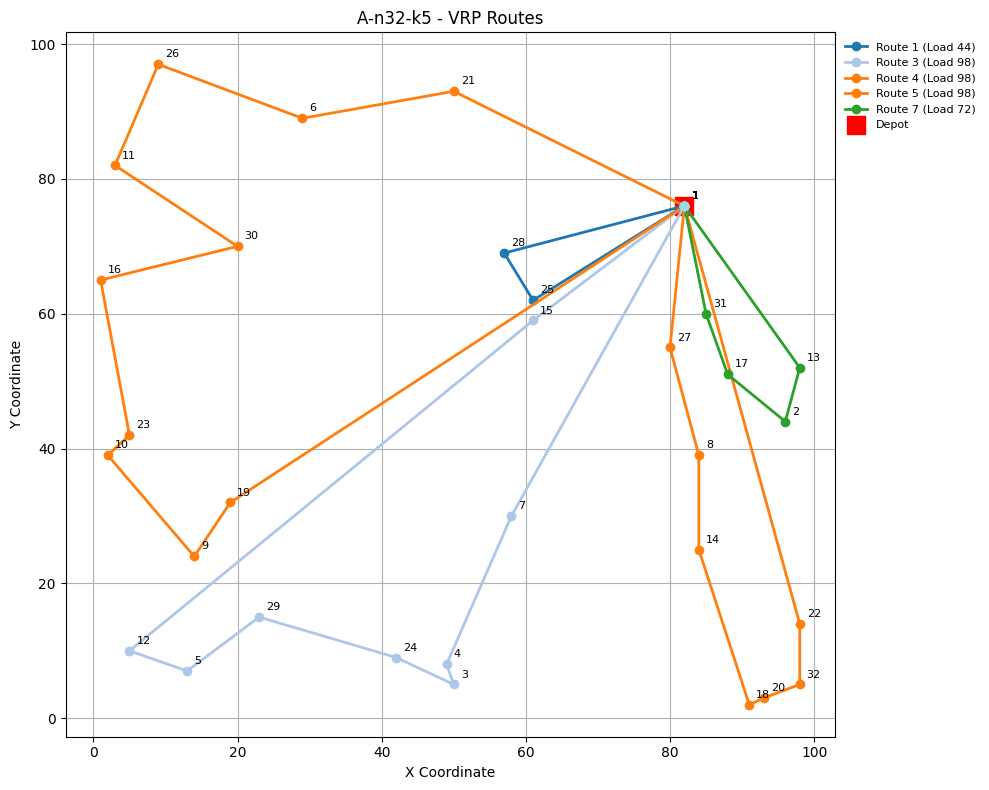


--- VRP Solution for A-n80-k10 ---
Total Distance Traveled: 1833

Routes (1-indexed):
  Route 1 (Load 100): [1, 64, 25, 7, 60, 28, 32, 18, 1]
  Route 2 (Load 100): [1, 35, 80, 3, 38, 9, 44, 17, 69, 79, 31, 1]
  Route 3 (Load 96): [1, 11, 72, 15, 49, 19, 29, 53, 12, 1]
  Route 4 (Load 98): [1, 39, 59, 33, 5, 23, 46, 68, 1]
  Route 5 (Load 0): [1, 1]
  Route 6 (Load 60): [1, 50, 74, 43, 14, 1]
  Route 7 (Load 100): [1, 54, 16, 57, 70, 66, 36, 27, 58, 20, 48, 42, 61, 1]
  Route 8 (Load 0): [1, 1]
  Route 9 (Load 0): [1, 1]
  Route 10 (Load 0): [1, 1]
  Route 11 (Load 0): [1, 1]
  Route 12 (Load 0): [1, 1]
  Route 13 (Load 0): [1, 1]
  Route 14 (Load 0): [1, 1]
  Route 15 (Load 0): [1, 1]
  Route 16 (Load 0): [1, 1]
  Route 17 (Load 0): [1, 1]
  Route 18 (Load 0): [1, 1]
  Route 19 (Load 0): [1, 1]
  Route 20 (Load 0): [1, 1]
  Route 21 (Load 0): [1, 1]
  Route 22 (Load 0): [1, 1]
  Route 23 (Load 0): [1, 1]
  Route 24 (Load 0): [1, 1]
  Route 25 (Load 0): [1, 1]
  Route 26 (Load 0): [1, 

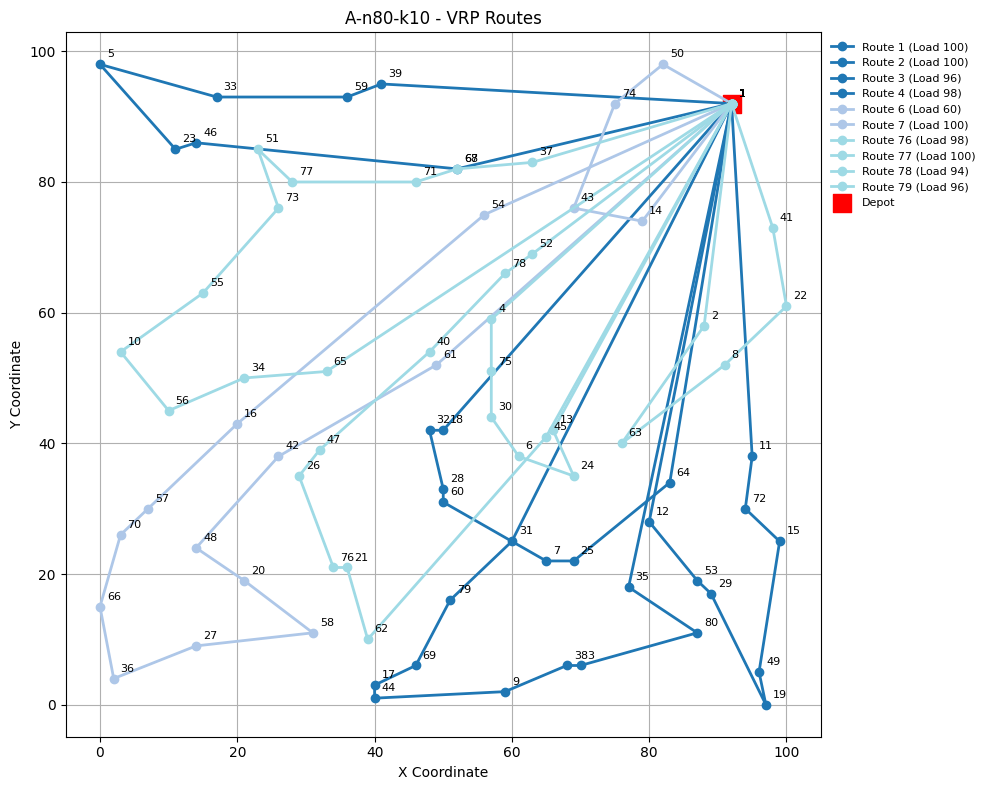

In [35]:
import math
import time
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import numpy as np

# Calculate Euclidean distance between two points
def calculate_distance(p1, p2):
    return math.hypot(p1[0] - p2[0], p1[1] - p2[1])

# Generate the distance matrix for all nodes
def generate_distance_matrix(coords):
    n = len(coords)
    matrix = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            matrix[i][j] = int(calculate_distance(coords[i], coords[j]))
    return matrix

# Solve the Vehicle Routing Problem using OR Tools
def solve_vrp_with_ortools(coords, demands, capacity, depot_index=0, time_limit_sec=10):
    n = len(coords)
    dist_matrix = generate_distance_matrix(coords)
    manager = pywrapcp.RoutingIndexManager(n, n-1, depot_index)
    routing_model = pywrapcp.RoutingModel(manager)

    # Define distance callback
    def distance_callback(from_idx, to_idx):
        from_node = manager.IndexToNode(from_idx)
        to_node = manager.IndexToNode(to_idx)
        return dist_matrix[from_node][to_node]

    transit_callback = routing_model.RegisterTransitCallback(distance_callback)
    routing_model.SetArcCostEvaluatorOfAllVehicles(transit_callback)

    # Define capacity constraint
    def demand_callback(from_idx):
        from_node = manager.IndexToNode(from_idx)
        return demands[from_node]

    demand_callback_index = routing_model.RegisterUnaryTransitCallback(demand_callback)
    routing_model.AddDimension(demand_callback_index, 0, capacity, True, "Capacity")

    # Set up search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.time_limit.seconds = time_limit_sec

    # Solve the VRP
    start_time = time.time()
    solution = routing_model.SolveWithParameters(search_parameters)
    total_time = time.time() - start_time

    result = {'routes': [], 'route_loads': [], 'total_distance': 0, 'solve_time': total_time}
    if solution:
        total_dist = 0
        for vehicle_id in range(routing_model.vehicles()):
            idx = routing_model.Start(vehicle_id)
            route = []
            load = 0
            while not routing_model.IsEnd(idx):
                node = manager.IndexToNode(idx)
                route.append(node)
                if node != depot_index:
                    load += demands[node]
                prev_idx = idx
                idx = solution.Value(routing_model.NextVar(idx))
                total_dist += routing_model.GetArcCostForVehicle(prev_idx, idx, vehicle_id)
            route.append(depot_index)
            result['routes'].append(route)
            result['route_loads'].append(load)
        result['total_distance'] = total_dist
    else:
        print("Solution not found!")

    return result

# Display results for the VRP solution
def display_vrp_solution(dataset_name, coords, demands, vehicle_capacity, optimal_value):
    print(f"\n--- VRP Solution for {dataset_name} ---")
    result = solve_vrp_with_ortools(coords, demands, vehicle_capacity, depot_index=0, time_limit_sec=10)
    total_dist = result['total_distance']
    gap_percentage = ((total_dist - optimal_value) / optimal_value) * 100
    print(f"Total Distance Traveled: {total_dist}")

    print("\nRoutes (1-indexed):")
    for i, route in enumerate(result['routes']):
        route_info = [node + 1 for node in route]  # Convert to 1-based index
        print(f"  Route {i+1} (Load {result['route_loads'][i]}): {route_info}")

    print(f"\nTime Taken: {result['solve_time']:.2f} seconds")
    print(f"Optimality Gap from Optimal: {gap_percentage:.2f}%")

    # Plot routes
    plot_routes(coords, result['routes'], result['route_loads'], dataset_name)

# Plot routes with unique colors for each route
def plot_routes(coords, routes, route_loads, title):
    plt.figure(figsize=(10, 8))

    # Set a different color for each route using a color palette
    cmap = plt.get_cmap("tab20", len(routes))  # Use "tab20" colormap

    for i, route in enumerate(routes):
        xs, ys = zip(*[coords[node] for node in route])
        plt.plot(xs, ys, marker='o', label=f"Route {i+1} (Load {route_loads[i]})", color=cmap(i), linewidth=2)

        # Annotate node names
        for node in route:
            x, y = coords[node]
            plt.annotate(str(node+1), (x, y), textcoords="offset points", xytext=(5, 5), fontsize=8)

    # Plot the depot (first node)
    depot_x, depot_y = coords[0]
    plt.scatter([depot_x], [depot_y], c='red', s=150, marker='s', label='Depot')

    # Title and labels
    plt.title(f"{title} - VRP Routes")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")

    # Improve legend to show only non-zero load routes
    handles, labels = plt.gca().get_legend_handles_labels()
    filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if "Load 0" not in l]
    plt.legend(*zip(*filtered_handles_labels), loc='upper left', bbox_to_anchor=(1, 1), fontsize=8, ncol=1, frameon=False)

    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

# Example datasets
coords_32 = [
    (82, 76), (96, 44), (50, 5), (49, 8), (13, 7), (29, 89), (58, 30),
    (84, 39), (14, 24), (2, 39), (3, 82), (5, 10), (98, 52), (84, 25),
    (61, 59), (1, 65), (88, 51), (91, 2), (19, 32), (93, 3), (50, 93),
    (98, 14), (5, 42), (42, 9), (61, 62), (9, 97), (80, 55), (57, 69),
    (23, 15), (20, 70), (85, 60), (98, 5)
]
demands_32 = [0, 19, 21, 6, 19, 7, 12, 16, 6, 16, 8, 14, 21, 16, 3, 22, 18, 19, 1, 24, 8, 12, 4, 8, 24, 24, 2, 20, 15, 2, 14, 9]
optimal_32 = 784

coords_80 = [
    (92, 92), (88, 58), (70, 6), (57, 59), (0, 98), (61, 38), (65, 22),
    (91, 52), (59, 2), (3, 54), (95, 38), (80, 28), (66, 42), (79, 74),
    (99, 25), (20, 43), (40, 3), (50, 42), (97, 0), (21, 19), (36, 21),
    (100, 61), (11, 85), (69, 35), (69, 22), (29, 35), (14, 9), (50, 33),
    (89, 17), (57, 44), (60, 25), (48, 42), (17, 93), (21, 50), (77, 18),
    (2, 4), (63, 83), (68, 6), (41, 95), (48, 54), (98, 73), (26, 38),
    (69, 76), (40, 1), (65, 41), (14, 86), (32, 39), (14, 24), (96, 5),
    (82, 98), (23, 85), (63, 69), (87, 19), (56, 75), (15, 63), (10, 45),
    (7, 30), (31, 11), (36, 93), (50, 31), (49, 52), (39, 10), (76, 40),
    (83, 34), (33, 51), (0, 15), (52, 82), (52, 82), (46, 6), (3, 26),
    (46, 80), (94, 30), (26, 76), (75, 92), (57, 51), (34, 21), (28, 80),
    (59, 66), (51, 16), (87, 11)
]
demands_80 = [0, 24, 22, 23, 5, 11, 23, 26, 9, 23, 9, 14, 16, 12, 2, 2, 6, 20, 26, 12, 15, 13, 26, 17, 7, 12, 4, 4, 20, 10,
              9, 2, 9, 1, 2, 2, 12, 14, 23, 21, 13, 13, 23, 3, 6, 23, 11, 2, 7, 13, 10, 3, 6, 13, 2, 14, 7, 21, 7, 22, 13,
              22, 18, 22, 6, 2, 11, 5, 9, 9, 5, 12, 2, 12, 19, 6, 14, 2, 2, 24]
optimal_80 = 1763

# Display results for both datasets
display_vrp_solution("A-n32-k5", coords_32, demands_32, vehicle_capacity=100, optimal_value=optimal_32)
display_vrp_solution("A-n80-k10", coords_80, demands_80, vehicle_capacity=100, optimal_value=optimal_80)



Comparing all the three methods:

For dataset 1

SIMULATED ANNEALING - Best distance: 836.90 ;; Gap: 6.75% ;; Computation Time: 0.31s ;; Route Summary: A total of 5 routes, with Route 5 having the least load (43).

GENETIC ALGO - Best Total Distance: 1392.63 ;; Gap: 77.63% ;; Computation Time: 1.92s ;; Route Summary:A total of 5 routes with varying loads, with the largest load on Route 1 (99).

OR TOOLS :  Total Distance Traveled: 773 ;; Time Taken: 10.00s ;; Gap from Optimal: -1.40% ;; Route Summary: A total of 7 routes, with the largest load on Route 3 (98).

For dataset 2

SIMULATED ANNEALING : Best Cost: 2198.39 ;; Gap: 24.70% ;; Computation Time: 0.64s ;; Route Summary:A total of 10 routes, with Route 5 having the smallest load (0)

GENETIC ALGO : Best Total Distance: 4008.54 ;; Gap: 127.37% ;; Computation Time: 5.29s ;; Route Summary: A total of 10 routes, with Route 1 having the largest load (100).

OR Tools: Total Distance Traveled: 1833 ;; Time Taken: 10.00s ;; Gap from Optimal: 3.97% ;; Route Summary:A total of 10 routes, with Route 1 having the largest load (100).

**OR Tools provide the best solution with the least total distance**

**Simulated annealing performs better than genetic algorithm**